In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# Definir la función que representa el sistema de ecuaciones diferenciales
def pendulum(t, y, L=1, g=9.81):
    theta, omega = y  # theta es el ángulo, omega es la velocidad angular
    dtheta_dt = omega
    domega_dt = -(g / L) * np.sin(theta)
    return np.array([dtheta_dt, domega_dt])

In [9]:
import os


def build_data(
    t_resolution=100,
    t_span=(0, 10),
    y0=np.array([np.pi / 2, 0]),
    L=1,
    g=9.81,
):
    data_filename = f"data/pendulum_tres{t_resolution}_tspa{t_span}.npy"
    t_eval = np.linspace(*t_span, t_resolution)
    solution = solve_ivp(
        pendulum, t_span, y0, t_eval=t_eval, args=(L, g), vectorized=True
    )

    y = solution.y.T
    results = np.vstack([solution.t, y[:, 0], y[:, 1]])

    np.save(data_filename, results)
    return results, data_filename

In [10]:
t_span = (0, 10000)
t_resolution = 100000000

In [11]:
results, data_filename = build_data(t_resolution=t_resolution, t_span=t_span)

In [12]:
data = np.load(data_filename)
# data = np.load("data/pendulum_tres100000000_tspa(0, 10000).npy")
print(data.shape)

(3, 100000000)


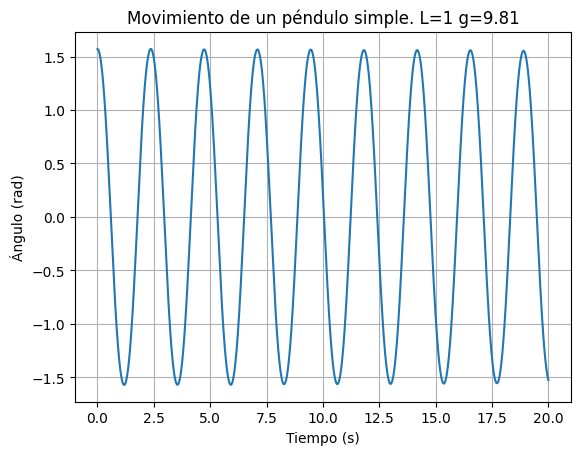

In [13]:
X = data[0, :200000]  # Time
y = data[1, :200000]  # Angle

# Graficar los resultados para un péndulo simple
plt.plot(X, y)
plt.xlabel("Tiempo (s)")
plt.ylabel("Ángulo (rad)")
plt.title(f"Movimiento de un péndulo simple. L={1} g={9.81}")
plt.grid(True)
plt.show()

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar los datos
scaler_X = MinMaxScaler()
X_normalized = scaler_X.fit_transform(X.reshape(-1, 1))

scaler_y = MinMaxScaler()
y_normalized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Dividir en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_normalized, test_size=0.2, random_state=42
)

In [15]:
# Creamos la FFNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential()
model.add(Input(shape=(1,)))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(1))

model.compile(optimizer=Adam(), loss="mse", metrics=[RootMeanSquaredError()])
model.summary()

2024-05-27 23:59:59.614294: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 00:00:00.815680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-28 00:00:01.879560: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-28 00:00:01.880663: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required li

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,921 (195.00 KB)

 Trainable params: 49,921 (195.00 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from datetime import datetime

epochs = 10000
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))
now = datetime.now().isoformat()
model_name = f"{now}_pendulum_tim{t_resolution}_epo{epochs}_row{len(X)}_spa{t_span}"
model.save(f"models/{model_name}.keras")
np.save(f"history/{model_name}.npy", history.history)

Epoch 1/1000
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 4.1855e-05 - root_mean_squared_error: 0.0065 - val_loss: 4.2209e-05 - val_root_mean_squared_error: 0.0065
Epoch 2/1000
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 4.1260e-05 - root_mean_squared_error: 0.0064 - val_loss: 3.6684e-05 - val_root_mean_squared_error: 0.0061
Epoch 3/1000
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 4.4171e-05 - root_mean_squared_error: 0.0066 - val_loss: 4.0013e-05 - val_root_mean_squared_error: 0.0063
Epoch 4/1000
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 4.8068e-05 - root_mean_squared_error: 0.0069 - val_loss: 5.9555e-05 - val_root_mean_squared_error: 0.0077
Epoch 5/1000
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 5.1797e-05 - root_mean_squared_error: 0.0072 - val_loss: 2.2683e-05 - val_root_mean_squared_error: 0.0048
Epoch 6/1000
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 4.2737e-05 - root_mean_squared_error: 0.0065 - val_loss: 3.6654e-05 - val_root_mean_s

In [18]:
from tensorflow.keras.saving import load_model

model = load_model(f"models/{model_name}.keras")

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.9778e-05 - root_mean_squared_error: 0.0071
Test Loss: [4.901805004919879e-05, 0.007001289166510105]
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step


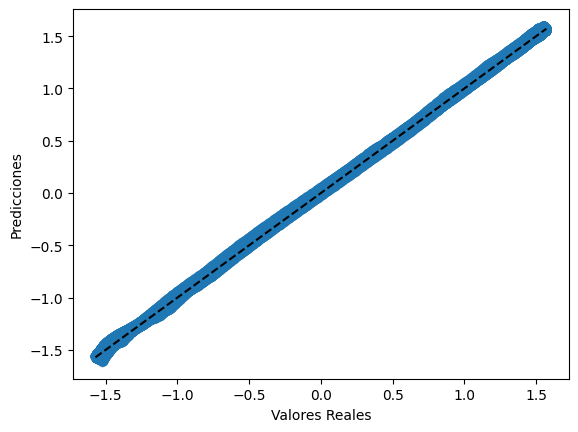

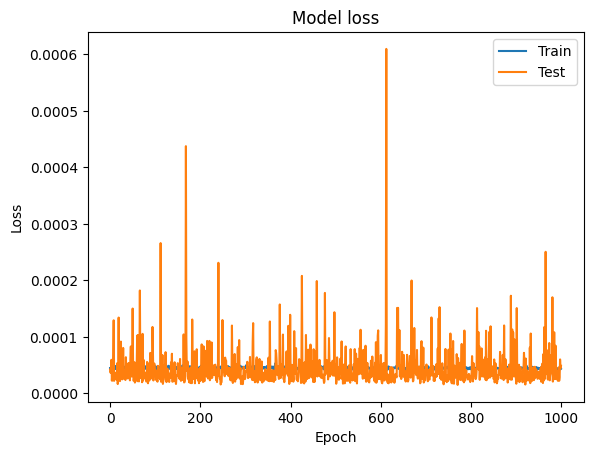

In [19]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Hacer predicciones
y_pred = model.predict(X_test)

# Desnormalizar las predicciones y los valores reales
y_test_denorm = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_denorm = scaler_y.inverse_transform(y_pred).flatten()

# Graficar las predicciones vs. los valores reales
plt.scatter(y_test_denorm, y_pred_denorm, alpha=0.5)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.plot(
    [y_test_denorm.min(), y_test_denorm.max()],
    [y_test_denorm.min(), y_test_denorm.max()],
    "k--",
)
plt.show()

# Graficamos el rendimiento del modelo
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Test")
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.show()

2.000005000025
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 5s 365us/step
[[ 1.0029469]
 [ 1.0029268]
 [ 1.0029069]
 ...
 [-3.035685 ]
 [-3.0356936]
 [-3.0357013]]


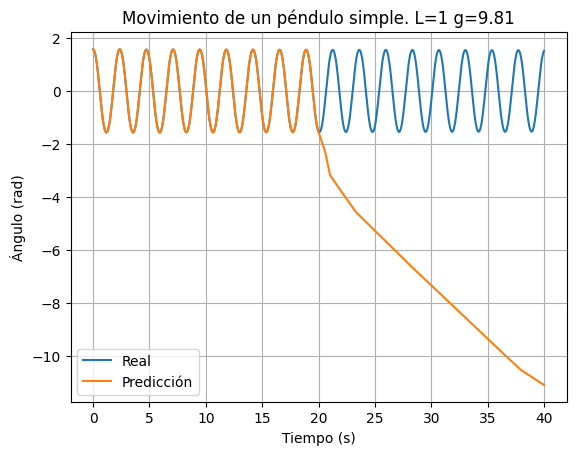

In [59]:
model = load_model(f"models/{model_name}.keras")
data = np.load(data_filename)
X_validate = data[0, :400000]
y_validate = data[1, :400000]

X_validate_normalized = scaler_X.transform(X_validate.reshape(-1, 1))
print(np.max(X_validate_normalized))
y_predict = model.predict(X_validate_normalized)
print(y_predict)
y_predict_denorm = scaler_y.inverse_transform(y_predict)

plt.plot(X_validate, y_validate)
plt.plot(X_validate, y_predict_denorm)
plt.xlabel("Tiempo (s)")
plt.ylabel("Ángulo (rad)")
plt.legend(["Real", "Predicción"])
plt.title(f"Movimiento de un péndulo simple. L={1} g={9.81}")
plt.grid(True)
plt.show()

In [28]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def draw_pendulums(L, pendulums_data):
    # Crear la figura y el eje
    fig, ax = plt.subplots()
    ax.set_xlim(-L - 0.5, L + 0.5)
    ax.set_ylim(-L - 0.5, L + 0.5)
    ax.set_aspect("equal")
    ax.grid(True)

    # Crear líneas que representarán los péndulos
    lines = [ax.plot([], [], "o-", lw=2)[0] for _ in pendulums_data]

    # Función de inicialización
    def init():
        for line in lines:
            line.set_data([], [])
        return lines

    # Función de actualización para la animación
    def update(t):
        theta = pendulums_data[:, t]
        x = L * np.sin(theta)
        y = -L * np.cos(theta)
        for i, line in enumerate(lines):
            line.set_data([0, x[i]], [0, y[i]])
        return lines

    # Crear la animación
    ani = FuncAnimation(
        fig, update, frames=t_resolution, init_func=init, blit=True, interval=30
    )

    # Mostrar la animación en el notebook
    return HTML(ani.to_jshtml())

In [1]:
pendulums_data = np.array([y_validate[:100000], y_predict_denorm[:100000]])
draw_pendulums(1, pendulums_data)

NameError: name 'np' is not defined

models/2024-05-20T22:56:39.226673_pendulum_tim1000_epo500_row1000_spa(0, 100).keras


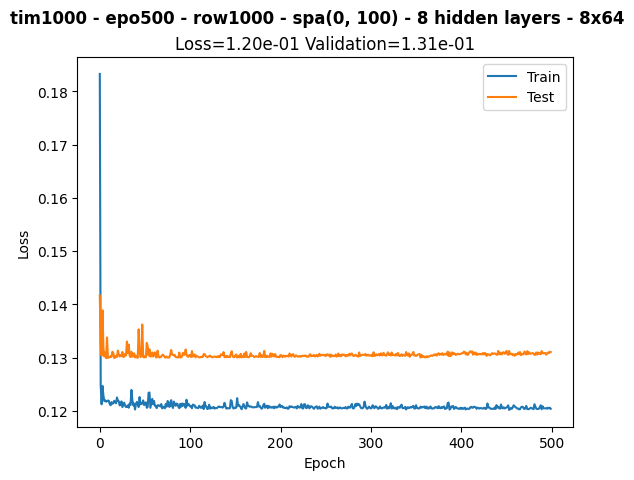

models/2024-05-27T19:41:11.946470_pendulum_tim100000000_epo1000_row200000_spa(0, 10000).keras


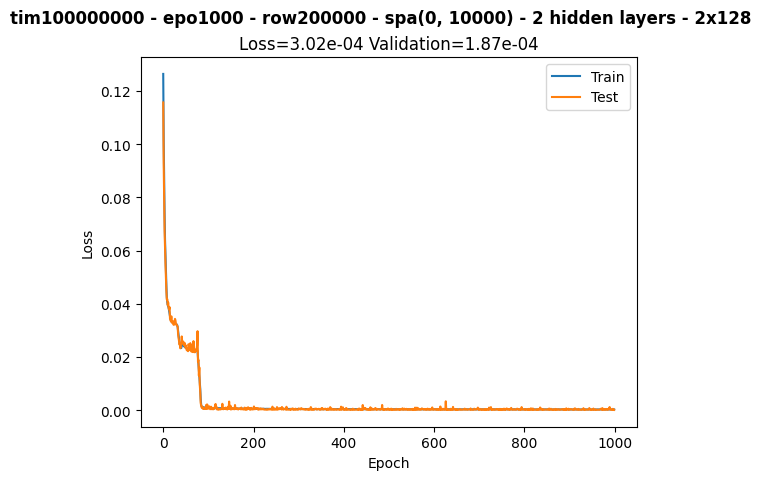

models/2024-05-20T23:10:14.435499_pendulum_tim10000_epo500_row10000_spa(0, 20).keras


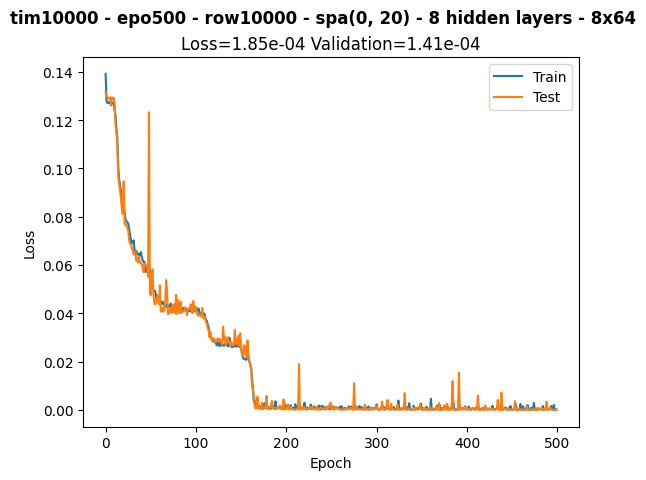

models/2024-05-20T21:35:42.197356_pendulum_tim10000_epo1000_row10000.keras


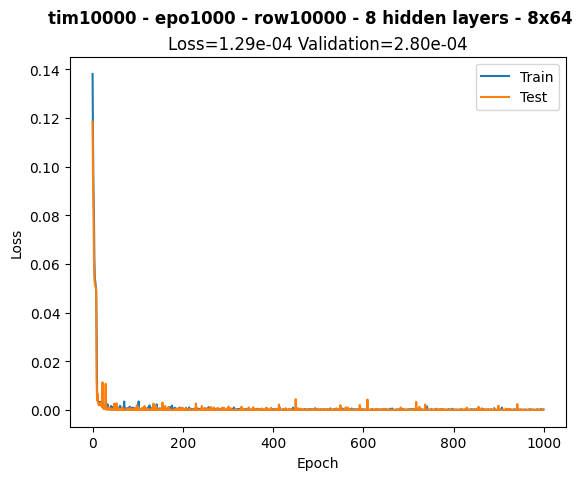

models/2024-05-25T10:42:37.365880_pendulum_tim1000_epo500_row1000_spa(0, 10).keras


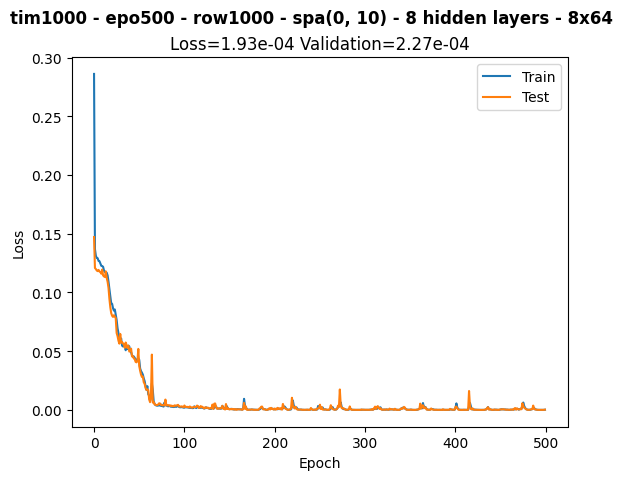

models/2024-05-21T23:54:50.147796_pendulum_tim1000_epo500_row1000_spa(0, 10).keras


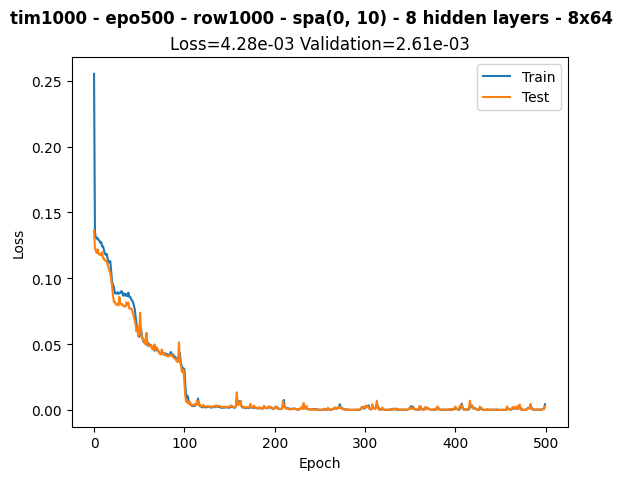

models/2024-05-20T22:25:37.594568_pendulum_tim1000_epo500_row1000_spa(0, 100).keras


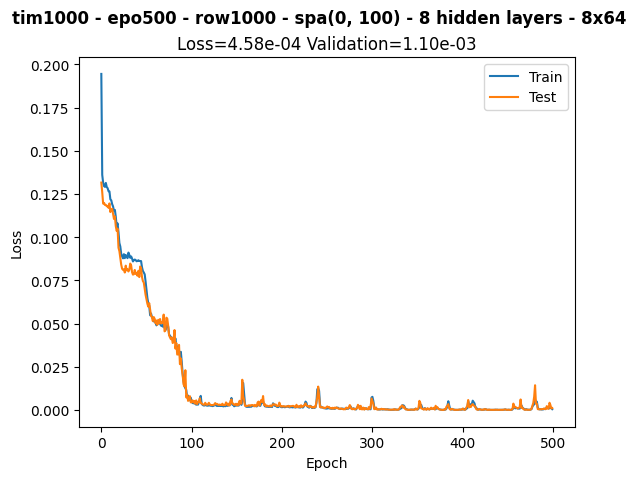

models/2024-05-27T18:32:43.734696_pendulum_tim100000000_epo1000_row200000_spa(0, 10000).keras


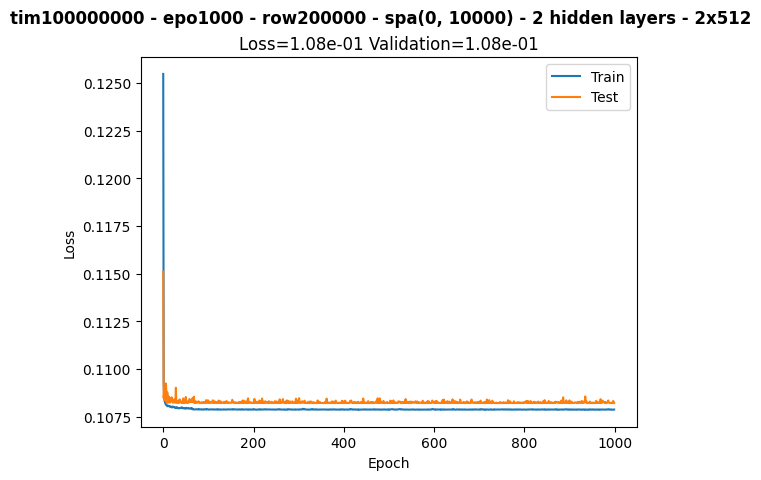

models/2024-05-27T22:51:48.326498_pendulum_tim100000000_epo1000_row200000_spa(0, 10000).keras


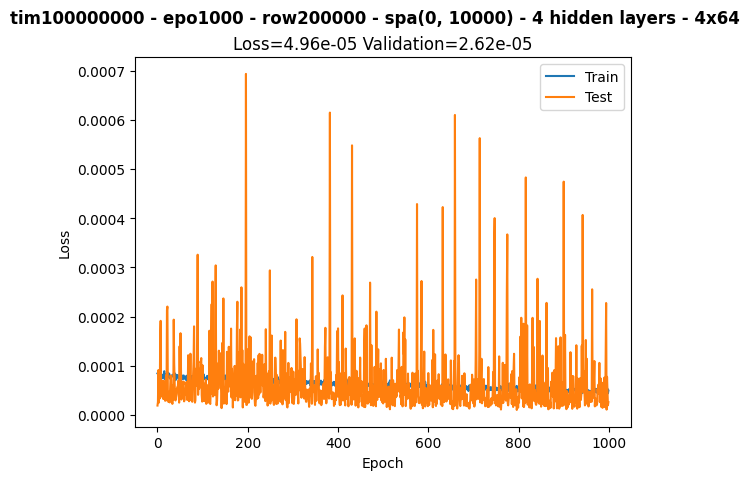

models/2024-05-20T21:20:32.068311_pendulum_tim100_epo1000_row100.keras


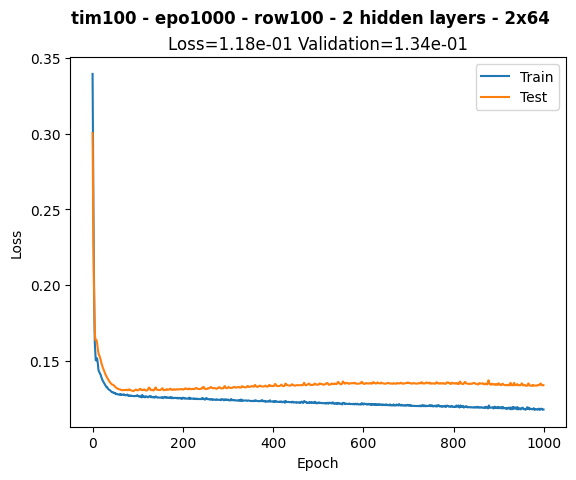

models/2024-05-20T21:59:10.702061_pendulum_tim1000_epo200_row1000.keras


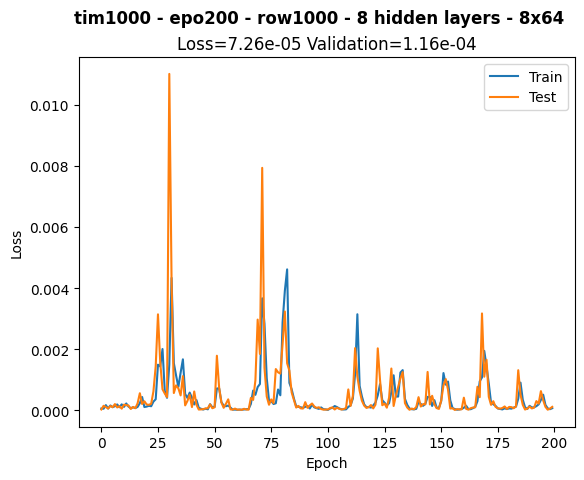

models/2024-05-20T21:52:18.416130_pendulum_tim1000_epo500_row1000.keras


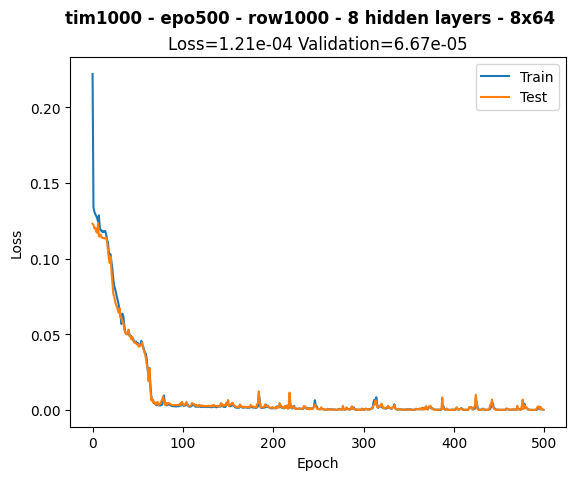

models/2024-05-27T18:13:32.864198_pendulum_tim100000000_epo1000_row200000_spa(0, 10000).keras


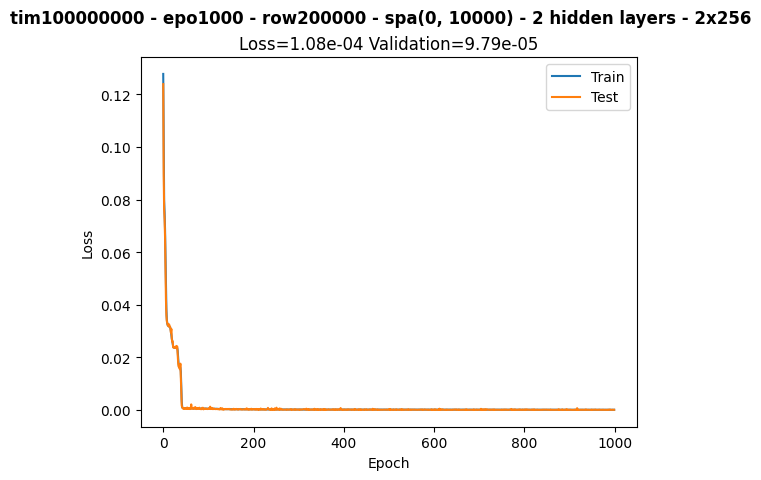

models/2024-05-20T20:25:40.045171_pendulum_tim100_epo1000_row100.keras


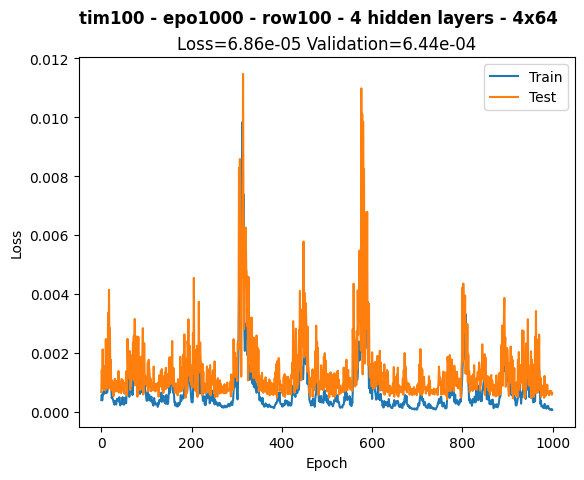

models/2024-05-25T10:37:13.908871_pendulum_tim100_epo500_row100_spa(0, 10).keras


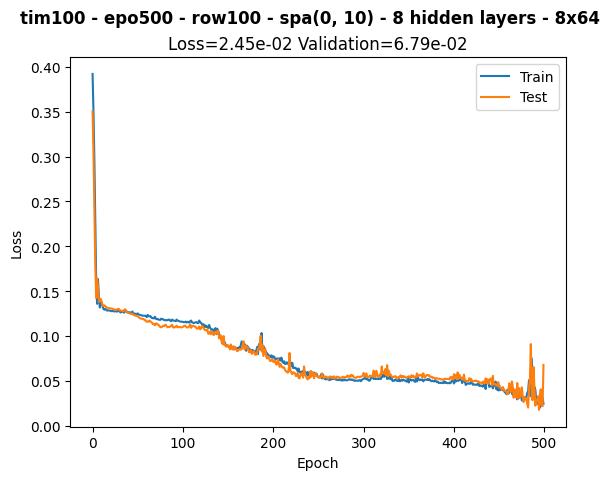

models/2024-05-20T22:20:08.549219_pendulum_tim1000_epo500_row1000.keras


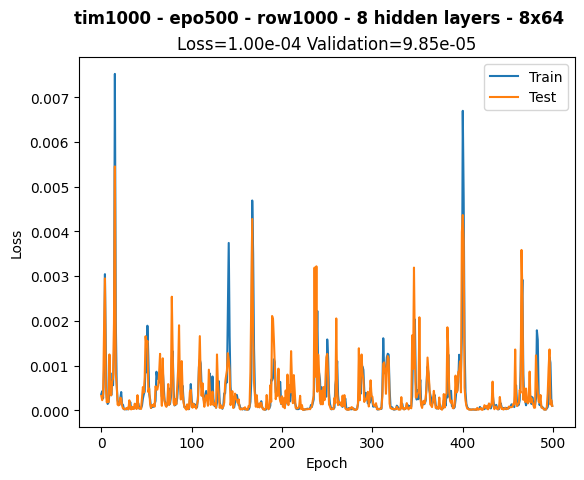

models/2024-05-20T23:37:01.976786_pendulum_tim1000_epo500_row1000_spa(0, 10).keras


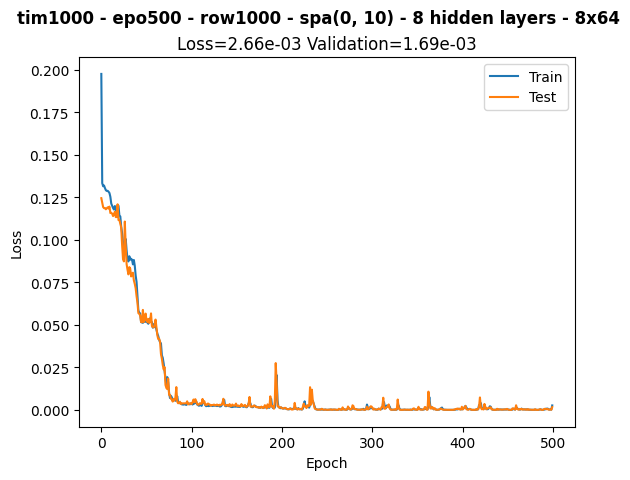

models/2024-05-28T07:14:40.652816_pendulum_tim100000000_epo10000_row200000_spa(0, 10000).keras


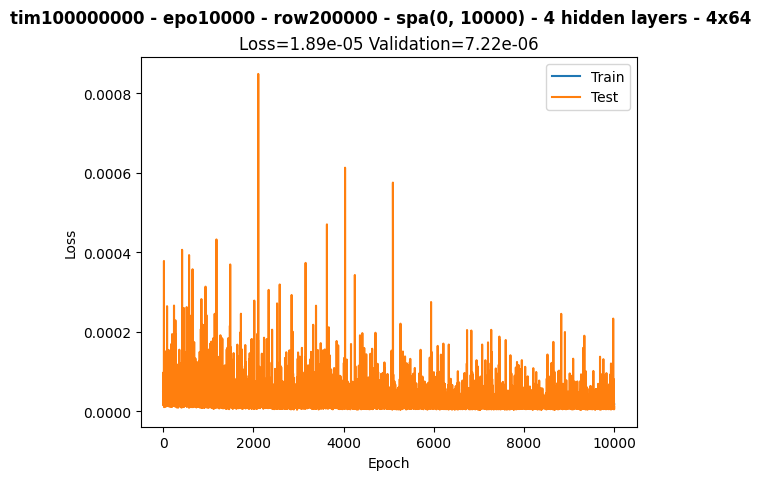

models/2024-05-27T21:31:20.209631_pendulum_tim100000000_epo1000_row200000_spa(0, 10000).keras


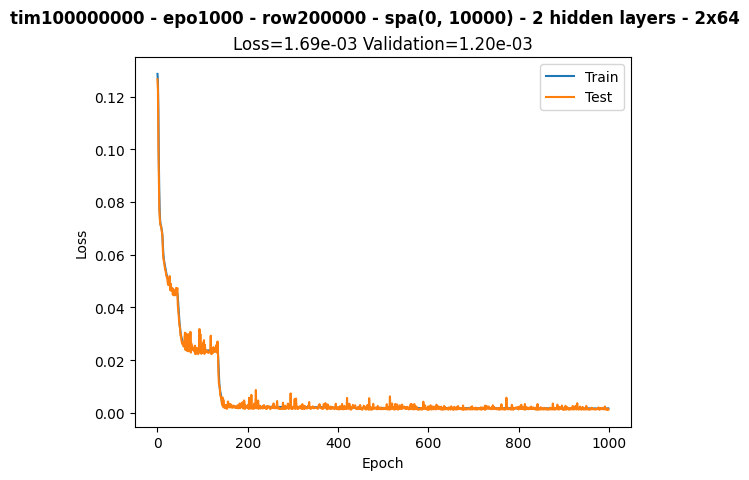

models/2024-05-20T23:02:51.617125_pendulum_tim10000_epo500_row10000_spa(0, 100).keras


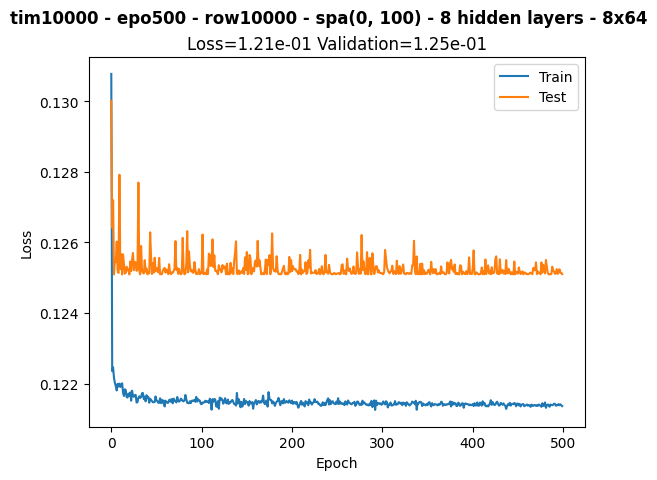

models/2024-05-25T10:41:16.718081_pendulum_tim100_epo500_row100_spa(0, 10).keras


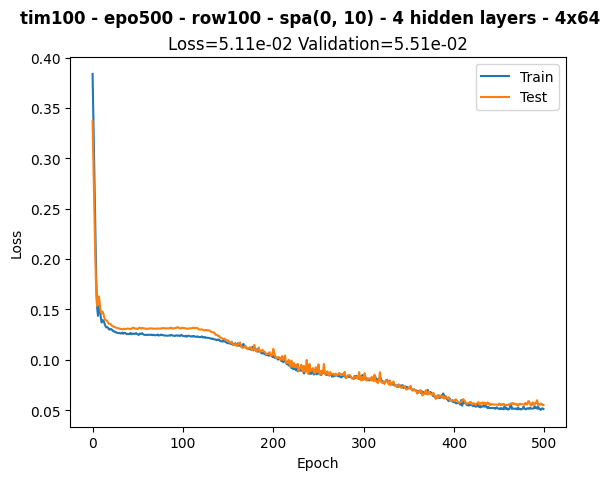

models/2024-05-20T21:22:03.335555_pendulum_tim100_epo1000_row100.keras


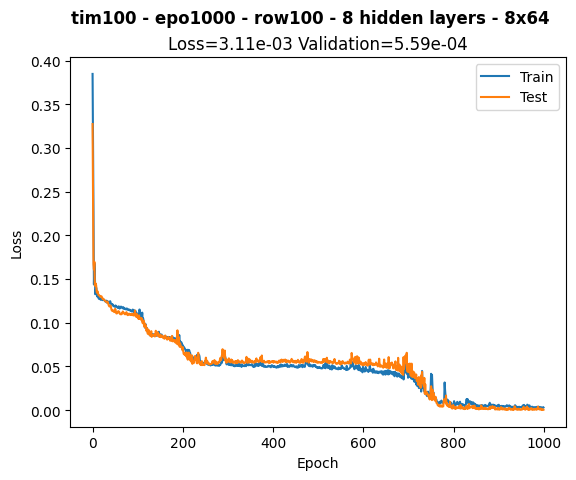

models/2024-05-20T20:51:57.519322_pendulum_tim100_epo1000_row100.keras


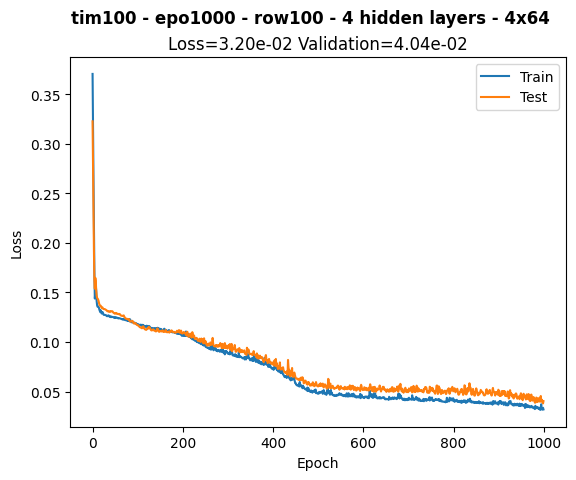

models/2024-05-28T10:24:20.510739_pendulum_tim100000000_epo1000_row200000_spa(0, 10000).keras


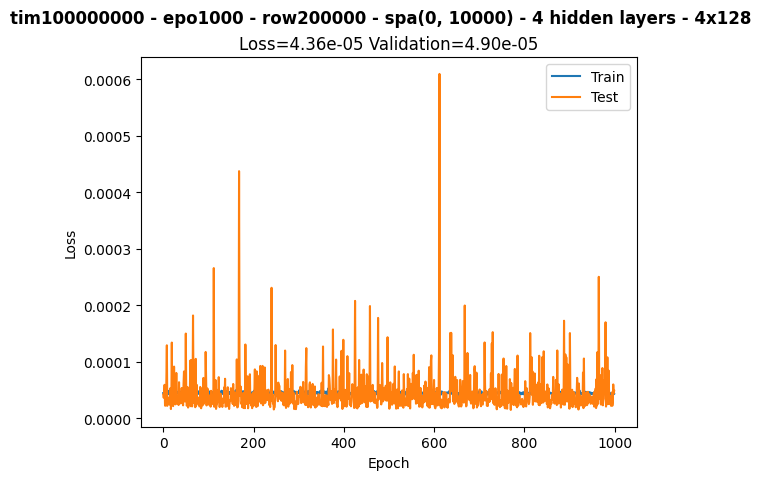

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import join
from pathlib import Path
from tensorflow.keras.saving import load_model

modelsMetrics = []

modelsPath = "./models"
for fileOrDir in listdir(modelsPath):
    path = Path(join(modelsPath, fileOrDir))
    if not path.is_file():
        continue

    file = fileOrDir

    print(path)
    model = load_model(path.absolute(), compile=False)
    history = np.load(f"history/{path.stem}.npy", allow_pickle=True).item()

    neurons, count = np.unique(
        [layer.output.shape[1] for layer in model.layers[:-1]], return_counts=True
    )

    title = (
        " - ".join(path.stem.split("_")[2:])
        + f" - {len(model.layers) - 1} hidden layers - "
        + " ".join([f"{count[i]}x{neurons[i]}" for i in range(len(neurons))])
    )

    last_loss = history["loss"][-1]
    last_val_loss = history["val_loss"][-1]

    modelsMetrics.append((file, last_loss, last_val_loss))

    # Graficamos el rendimiento del modelo
    plt.plot(history["loss"], label="Train")
    plt.plot(history["val_loss"], label="Test")
    plt.suptitle(title, fontweight="bold")
    plt.title(f"Loss={'%.2e' % last_loss} Validation={'%.2e' % last_val_loss}")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.savefig(f"{join('informe/other-models/', path.stem)}.jpg")
    plt.show()

In [12]:
modelsMetrics.sort(key=lambda item: item[2])
print(modelsMetrics[0])

('2024-05-28T07:14:40.652816_pendulum_tim100000000_epo10000_row200000_spa(0, 10000).keras', 1.8925193217000924e-05, 7.2213365456264e-06)


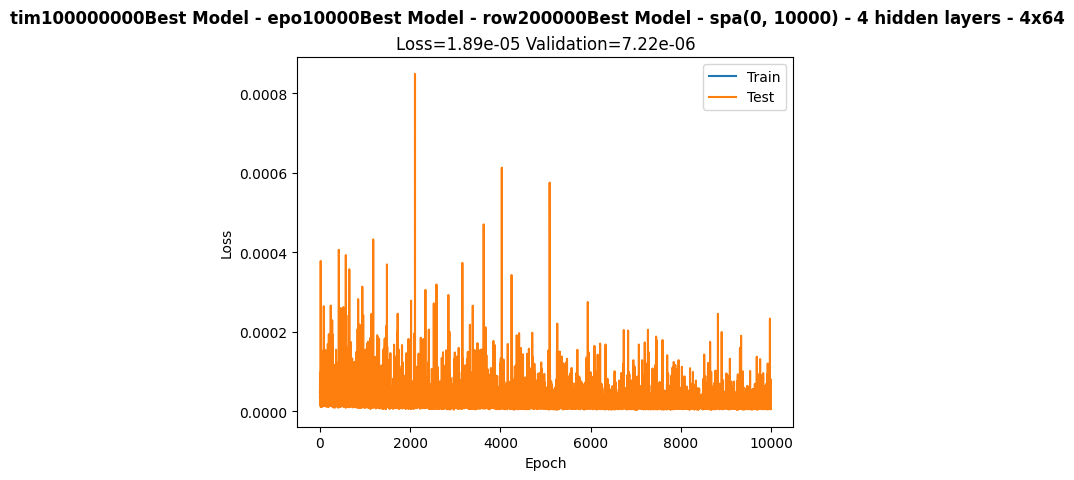

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 5s 748us/step


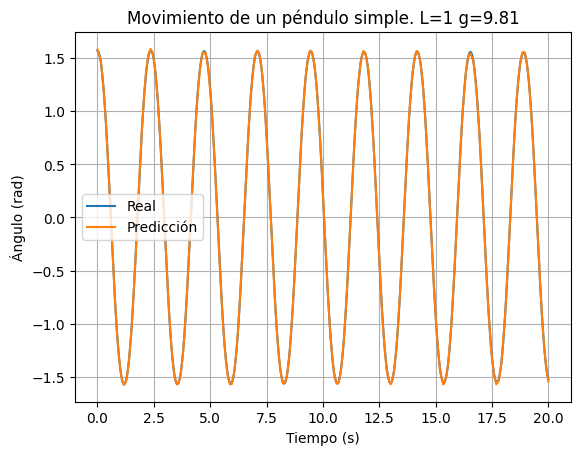

In [13]:
import matplotlib.pyplot as plt
from os import listdir
from os.path import join
from pathlib import Path
from tensorflow.keras.saving import load_model
from sklearn.preprocessing import MinMaxScaler


file = modelsMetrics[0][0]
path = Path(join(modelsPath, file))

best_model = load_model(path.absolute())
history = np.load(f"history/{path.stem}.npy", allow_pickle=True).item()

neurons, count = np.unique(
    [layer.output.shape[1] for layer in best_model.layers[:-1]], return_counts=True
)

title = (
    "Best Model - ".join(path.stem.split("_")[2:])
    + f" - {len(best_model.layers) - 1} hidden layers - "
    + " ".join([f"{count[i]}x{neurons[i]}" for i in range(len(neurons))])
)

last_loss = history["loss"][-1]
last_val_loss = history["val_loss"][-1]

modelsMetrics.append((path.stem, last_loss, last_val_loss))

# Graficamos el rendimiento del modelo
plt.plot(history["loss"], label="Train")
plt.plot(history["val_loss"], label="Test")
plt.suptitle(title, fontweight="bold")
plt.title(f"Loss={'%.2e' % last_loss} Validation={'%.2e' % last_val_loss}")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

data = np.load("data/pendulum_tres100000000_tspa(0, 10000).npy")
X_validate = data[0, :200000]
y_validate = data[1, :200000]

scaler_X = MinMaxScaler()
X_validate_normalized = scaler_X.fit_transform(X_validate.reshape(-1, 1))
scaler_y = MinMaxScaler()
scaler_y.fit(y_validate.reshape(-1, 1))

y_predict = best_model.predict(X_validate_normalized)
y_predict_denorm = scaler_y.inverse_transform(y_predict).flatten()

plt.plot(X_validate, y_validate)
plt.plot(X_validate, y_predict_denorm)
plt.xlabel("Tiempo (s)")
plt.ylabel("Ángulo (rad)")
plt.legend(["Real", "Predicción"])
plt.title(f"Movimiento de un péndulo simple. L={1} g={9.81}")
plt.grid(True)
plt.show()